In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from emtf_algos_v1 import *

In [2]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

np.random.seed(2026)

logger = get_logger()

import tensorflow as tf
import keras
from keras import backend as K
import matplotlib as mpl
import matplotlib.pyplot as plt

logger.info('Using cmssw      : {0}'.format(os.environ['CMSSW_VERSION'] if 'CMSSW_VERSION' in os.environ else 'n/a'))
logger.info('Using numpy      : {0}'.format(np.__version__))
logger.info('Using tensorflow : {0}'.format(tf.__version__))
logger.info('Using keras      : {0}'.format(keras.__version__))
logger.info('.. list devices  : {0}'.format(K.get_session().list_devices()))
logger.info('Using matplotlib : {0}'.format(mpl.__version__))

%matplotlib inline

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-requests/2.21.0-pafccj2/lib/python2.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (2.2.1) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.
[INFO    ] Using cmssw      : CMSSW_10_6_3
[INFO    ] Using numpy      : 1.16.2
[INFO    ] Using tensorflow : 1.6.0
[INFO    ] Using keras      : 2.2.4
[INFO    ] .. list devices  : [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using matplotlib : 2.2.4


In [3]:
# Input files

signal = 'signal_add.0.npz'

bkgnd = 'bkgnd_add.0.npz'

In [4]:
# Load input files

def load_signal(f):
  with np.load(f) as loaded:
    out_part = loaded['out_part']
    out_hits = RaggedTensorValue(loaded['out_hits_values'], loaded['out_hits_row_splits'])
    out_simhits = RaggedTensorValue(loaded['out_simhits_values'], loaded['out_simhits_row_splits'])
    print('[INFO] out_part: {0} out_hits: {1} out_simhits: {2}'.format(out_part.shape, out_hits.shape, out_simhits.shape))
  return (out_part, out_hits, out_simhits)

def load_bkgnd(f):
  with np.load(f) as loaded:
    out_hits = RaggedTensorValue(loaded['out_hits_values'], loaded['out_hits_row_splits'])
    print('[INFO] out_hits_bkgnd: {0}'.format(out_hits.shape))
  return (out_hits,)

In [5]:
part_arrays, hits_arrays, simhits_arrays = load_signal(signal)
bkghits_arrays, = load_bkgnd(bkgnd)

[INFO] out_part: (1044081, 10) out_hits: (1044081, None, 8) out_simhits: (1044081, None, 8)
[INFO] out_hits_bkgnd: (16289880, None, 8)


In [6]:
# Debug
print(part_arrays[0], hits_arrays[0], simhits_arrays[0])
print(part_arrays[1], hits_arrays[1], simhits_arrays[1])
print(part_arrays[2], hits_arrays[2], simhits_arrays[2])
print(part_arrays[3], hits_arrays[3], simhits_arrays[3])

[ -0.07286745   1.981351     2.1438558   24.857655   -25.86196
   1.2163241    6.3448358   -0.648671     2.           0.        ] [[  0   0  42 667  14  12   0  -1]
 [  0   3  50 804   0  18   0   0]
 [  0   4  51 813   2  18   0  -1]
 [  0   5  52 831   1  18   0   1]
 [  0   6  52 833   0  19   0   1]
 [  0   7  53 840   0  19  19   1]
 [  0   8  53 846   0  19   0   0]] [[  0   0  42 664   0  13   0   0]
 [  0   2  45 724   0  14   0   0]
 [  0   3  50 804   0  17   0   0]
 [  0   4  51 813   0  18   0   0]
 [  0   5  52 828   0  18   0   0]
 [  0   6  52 834   0  19   0   0]
 [  0   7  53 840   0  19   0   0]
 [  0   8  53 845   0  19   0   0]]
[1.6307077e-01 1.5877699e+00 7.2498721e-01 1.7160455e+02 1.0059981e+02
 6.9927592e+00 7.0719070e+01 2.6855508e-02 0.0000000e+00 2.0000000e+00] [[   2    2  151 2408    0   88    0   -1]
 [   2    4  155 2476    3   85    0   -1]
 [   2    5  155 2484    0   84    0   -2]
 [   2    6  157 2510    4   82    0   -1]
 [   2    7  157 2512    0  

In [7]:
# Build images

class Particle(object):
  def __init__(self, part_array):
    self.invpt = part_array[0]
    self.eta = part_array[1]
    self.phi = part_array[2]
    self.vx = part_array[3]
    self.vy = part_array[4]
    self.vz = part_array[5]
    self.d0 = part_array[6]
    self.phi_s = part_array[7]
    self.sector = part_array[8]
    self.zone = part_array[9]

  def get_parameters(self):
    return np.array([self.invpt, self.d0, self.eta, self.phi, self.invpt], dtype=np.float32)

class Hit(object):
  def __init__(self, hit_array):
    self.zone = hit_array[0]
    self.zone_row = hit_array[1]
    self.zone_col = hit_array[2]
    self.emtf_phi = hit_array[3]
    self.emtf_bend = hit_array[4]
    self.emtf_theta = hit_array[5]
    self.emtf_theta_alt = hit_array[6]
    self.emtf_qual = hit_array[7]

  def get_channels(self):
    f0 = 1.0  # valid flag
    f1 = (1.0 * self.emtf_phi / coarse_emtf_strip) - (1.0 * self.zone_col)
    f2 = 1.0 * self.emtf_bend
    return np.array([f0, f1, f2], dtype=np.float32)

def build_image(zone, part_array, hits_array, simhits_array, bkghits_array):
  num_channels = 1 + 2
  num_cols, col_offset = 300, 20  # truncate the first 20 unit
  num_rows = 10
  assert((max_emtf_strip//coarse_emtf_strip) == num_cols + col_offset)

  img = np.zeros((num_rows, num_cols, num_channels), dtype=np.float32)
  img_gt = np.zeros((num_rows, num_cols, num_channels), dtype=np.float32)

  for hit_array in hits_array:
    hit = Hit(hit_array)
    if hit.zone != zone:
      continue
    if hit.zone_col < col_offset:
      continue
    img[hit.zone_row, (hit.zone_col - col_offset)] = hit.get_channels()

  for simhit_array in simhits_array:
    simhit = Hit(simhit_array)
    if simhit.zone != zone:
      continue
    if simhit.zone_col < col_offset:
      continue
    img_gt[simhit.zone_row, (simhit.zone_col - col_offset)] = simhit.get_channels()
  return (img, img_gt)

def build_images(zone, part_arrays, hits_arrays, simhits_arrays, bkghits_arrays, num=-1):
  images = []
  images_gt = []
  params = []

  zipped = zip(part_arrays, hits_arrays, simhits_arrays, bkghits_arrays)

  for (part_array, hits_array, simhits_array, bkghits_array) in zipped:
    if len(images) == num:
      break

    part = Particle(part_array)
    if part.zone != zone:
      continue

    img, img_gt = build_image(zone, part_array, hits_array, simhits_array, bkghits_array)
    images.append(img)
    images_gt.append(img_gt)
    params.append(part.get_parameters())
  return (images, images_gt, params)

In [8]:
zone = 0
num = 20000

images, images_gt, params = build_images(zone, part_arrays, hits_arrays, simhits_arrays, bkghits_arrays, num=num)

In [9]:
# Debug
print(len(images), len(images_gt), len(params))
print(images[0].shape, images_gt[0].shape, params[0].shape)
print(np.nonzero(images[0]), np.nonzero(images_gt[0]), params[0])

20000 20000 20000
(10, 300, 3) (10, 300, 3) (5,)
(array([0, 0, 0, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 7, 7, 8, 8]), array([22, 22, 22, 30, 30, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 33]), array([0, 1, 2, 0, 1, 0, 1, 2, 0, 1, 2, 0, 1, 0, 1, 0, 1])) (array([0, 0, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8]), array([22, 22, 25, 25, 30, 30, 31, 31, 32, 32, 32, 32, 33, 33, 33, 33]), array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])) [-0.07286745  6.3448358   1.981351    2.1438558  -0.07286745]


In [10]:
# Debug
print(images[0][np.nonzero(images[0][...,0])])
print(images[1][np.nonzero(images[1][...,0])])
print(images[2][np.nonzero(images[2][...,0])])
print(images[3][np.nonzero(images[3][...,0])])

[[ 1.     -0.3125 14.    ]
 [ 1.      0.25    0.    ]
 [ 1.     -0.1875  2.    ]
 [ 1.     -0.0625  1.    ]
 [ 1.      0.0625  0.    ]
 [ 1.     -0.5     0.    ]
 [ 1.     -0.125   0.    ]]
[[ 1.     -0.1875  0.    ]
 [ 1.     -0.25    9.    ]
 [ 1.      0.4375  4.    ]
 [ 1.     -0.5     5.    ]
 [ 1.     -0.375   0.    ]
 [ 1.      0.125   1.    ]
 [ 1.      0.0625  0.    ]]
[[ 1.     -0.375  -7.    ]
 [ 1.      0.0625 -8.    ]
 [ 1.     -0.5    -8.    ]]
[[  1.       0.4375 -20.    ]
 [  1.      -0.3125  -5.    ]
 [  1.      -0.375    0.    ]
 [  1.      -0.5      0.    ]
 [  1.       0.       0.    ]
 [  1.      -0.1875   0.    ]
 [  1.       0.3125   0.    ]]


In [11]:
# Styling
plt.style.use('tdrstyle.mplstyle')

# Color maps
from matplotlib.colors import LinearSegmentedColormap
cdict = {
  'blue' : ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
blue_hot = LinearSegmentedColormap('blue_hot', cdict)

cdict = {
  'blue' : ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
green_hot = LinearSegmentedColormap('green_hot', cdict)

zone_row_labels = [
  ['ME0'  , 'GE1/1', 'ME1/1', 'GE2/1', 'ME2/1', 'ME3/1', 'RE3/1', 'ME4/1', 'RE4/1', 'none' ],
  ['GE1/1', 'ME1/1', 'ME1/2', 'RE1/2', 'GE2/1', 'ME2/1', 'ME3/1', 'RE3/1', 'ME4/1', 'RE4/1'],
  ['ME1/2', 'RE1/2', 'RE2/2', 'ME2/2', 'ME3/2', 'RE3/2', 'ME4/2', 'RE4/2', 'none' , 'none' ],
  ['MB1'  , 'MB2'  , 'MB3'  , 'ME1/3', 'RE1/3', 'RE2/3', 'ME2/2', 'ME3/2', 'RE3/3', 'ME4/2'],
]

In [12]:
# Display image

def display_image(zone, img, cmap=blue_hot, figsize=(10,2)):
  fig, ax = plt.subplots(1, 1, figsize=figsize)
  ax.imshow(img[...,0], origin='lower', interpolation='none', aspect='auto',
            cmap=cmap, vmin=0, vmax=1.6)
  ax.set_yticks(range(len(zone_row_labels[zone])))
  ax.set_yticklabels(zone_row_labels[zone], fontsize=7)
  plt.show()

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


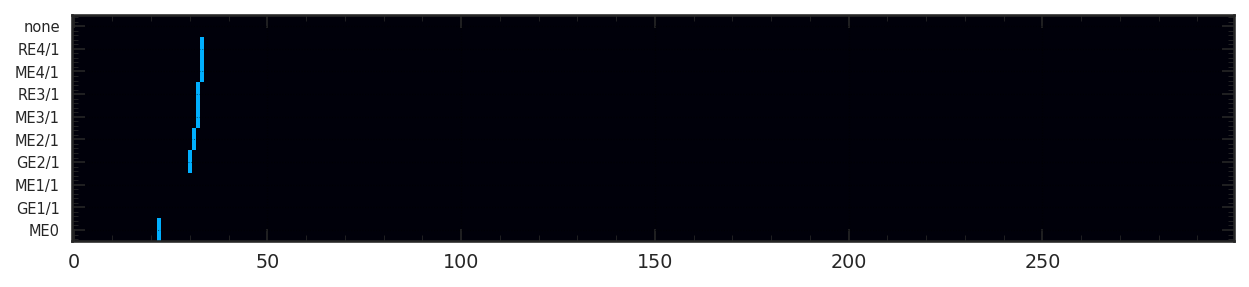

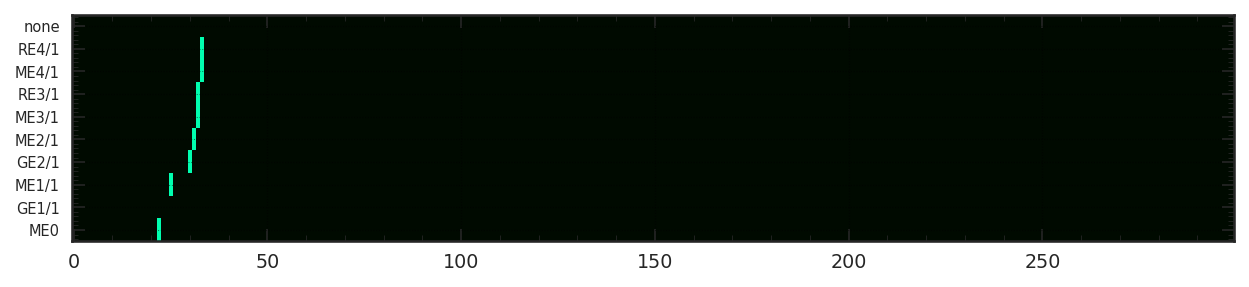

In [13]:
display_image(zone, images[0])
display_image(zone, images_gt[0], cmap=green_hot)

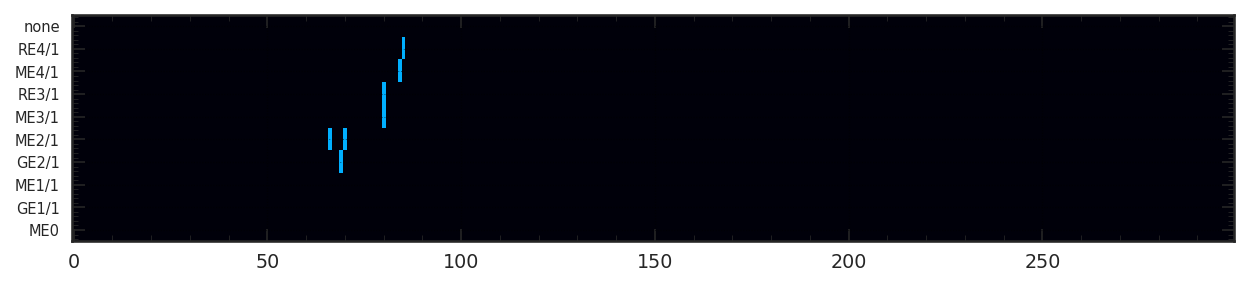

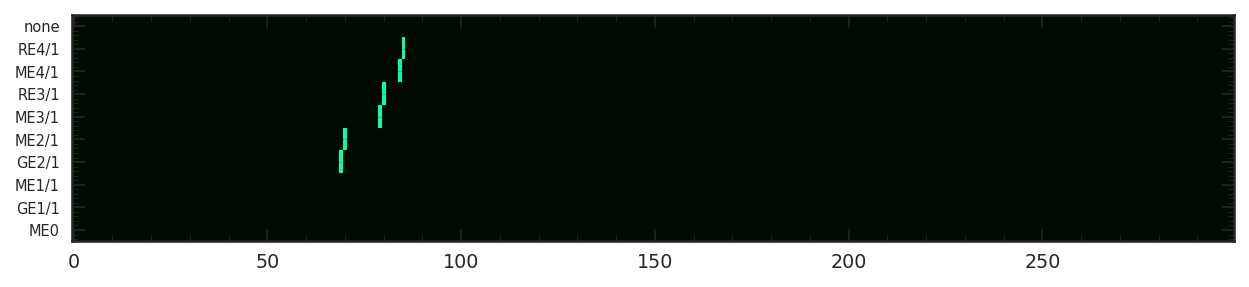

In [14]:
display_image(zone, images[1])
display_image(zone, images_gt[1], cmap=green_hot)

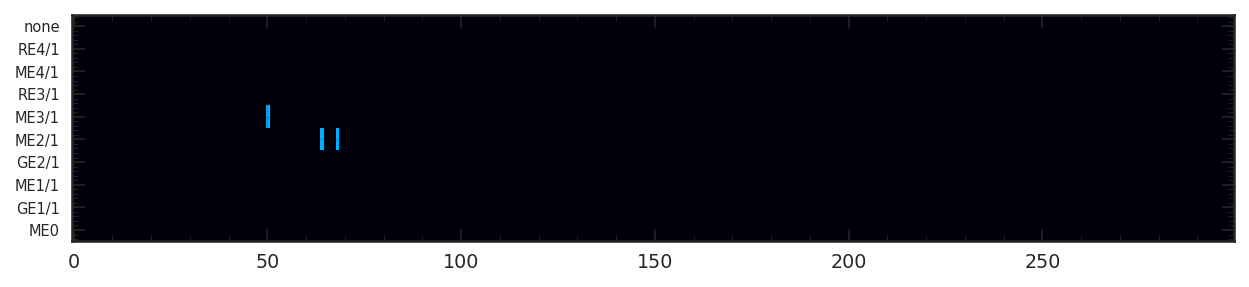

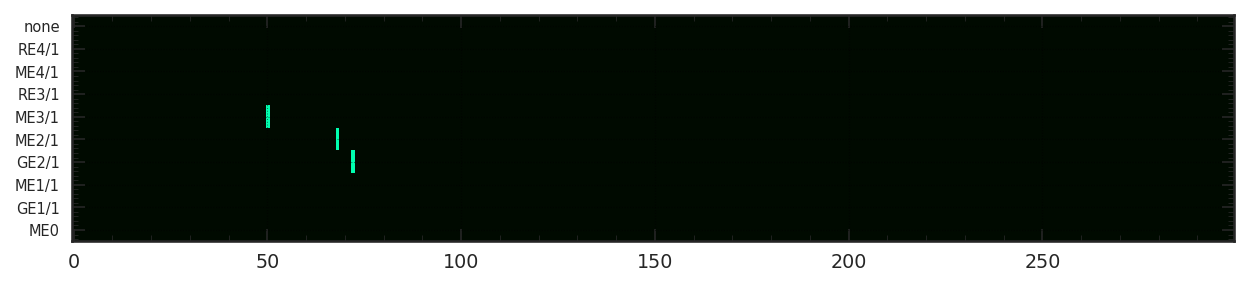

In [15]:
display_image(zone, images[2])
display_image(zone, images_gt[2], cmap=green_hot)

### VAE

In [16]:
# From https://github.com/google/brain-tokyo-workshop/blob/master/WANNRelease/vae/vae.py
# Used for research purposes only.

class ConvVAE(object):
  def __init__(self, z_size=32, batch_size=1, num_channel=3, learning_rate=1e-3, kl_tolerance=0.5, is_training=False, reuse=False, gpu_mode=False):
    self.z_size = z_size
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.is_training = is_training
    self.kl_tolerance = kl_tolerance
    self.num_channel = num_channel
    self.reuse = reuse
    with tf.variable_scope('conv_vae', reuse=self.reuse):
      if not gpu_mode:
        with tf.device('/cpu:0'):
          tf.logging.info('Model using cpu.')
          self._build_graph()
      else:
        tf.logging.info('Model using gpu.')
        self._build_graph()
    self._init_session()
  def _build_graph(self):
    self.g = tf.Graph()
    with self.g.as_default():
      tf.set_random_seed(2026)

      self.x = tf.placeholder(tf.float32, shape=[None, 10, 300, self.num_channel])

      # Encoder
      h = tf.layers.conv2d(self.x, 32, (10,10), strides=(1,4), activation=tf.nn.relu, name="enc_conv1")
      print(h.shape)
      h = tf.layers.conv2d(h, 64, (1,10), strides=(1,4), activation=tf.nn.relu, name="enc_conv2")
      print(h.shape)
      h = tf.layers.conv2d(h, 128, (1,10), strides=(1,4), activation=tf.nn.relu, name="enc_conv3")
      print(h.shape)
      #h = tf.layers.conv2d(h, 256, (1,4), strides=(1,2), activation=tf.nn.relu, name="enc_conv4")
      #print(h.shape)
      h = tf.reshape(h, [-1, 2*128])
      print(h.shape)

      # VAE
      self.mu = tf.layers.dense(h, self.z_size, name="enc_fc_mu")
      self.logvar = tf.layers.dense(h, self.z_size, name="enc_fc_log_var")
      self.sigma = tf.exp(self.logvar / 2.0)
      self.epsilon = tf.random_normal([tf.shape(self.mu)[0], self.z_size])
      self.z = self.mu + self.sigma * self.epsilon

      # Decoder
      h = tf.layers.dense(self.z, 2*128, name="dec_fc")
      print(h.shape)
      h = tf.reshape(h, [-1, 1, 1, 2*128])
      print(h.shape)
      #h = tf.layers.conv2d_transpose(h, 128, (1,4), strides=(1,2), activation=tf.nn.relu, name="dec_deconv1")
      #print(h.shape)
      h = tf.layers.conv2d_transpose(h, 64, (1,16), strides=(1,4), activation=tf.nn.relu, name="dec_deconv2")
      print(h.shape)
      h = tf.layers.conv2d_transpose(h, 32, (1,13), strides=(1,4), activation=tf.nn.relu, name="dec_deconv3")
      print(h.shape)
      self.y = tf.layers.conv2d_transpose(h, self.num_channel, (10,12), strides=(1,4), activation=tf.nn.sigmoid, name="dec_deconv4")
      print(self.y.shape)

      # train ops
      if self.is_training:
        self.global_step = tf.Variable(0, name='global_step', trainable=False)

        eps = 1e-7 # avoid taking log of zero

        target = self.x[...,0:1]
        output = self.y[...,0:1]
        pos_weight = 5.
        bce = target * -tf.log(output + eps) * pos_weight + (1 - target) * -tf.log(1 - output + eps)

        bce_mask = tf.reduce_sum(
          target,
          reduction_indices = [2,3]
        )
        bce_mask = tf.cast(tf.greater(bce_mask, 0), tf.float32)
        bce_mask = tf.expand_dims(tf.expand_dims(bce_mask, -1), -1)
        bce *= bce_mask

        # reconstruction loss
        self.r_loss = tf.reduce_sum(
          bce,
          reduction_indices = [1,2,3]
        )
        self.r_loss = tf.reduce_mean(self.r_loss)

        # augmented kl loss per dim
        self.kl_loss = - 0.5 * tf.reduce_sum(
          (1 + self.logvar - tf.square(self.mu) - tf.exp(self.logvar)),
          reduction_indices = 1
        )
        self.kl_loss = tf.maximum(self.kl_loss, self.kl_tolerance * self.z_size)
        self.kl_loss = tf.reduce_mean(self.kl_loss)

        self.loss = self.r_loss + self.kl_loss

        # training
        self.lr = tf.Variable(self.learning_rate, trainable=False)
        self.optimizer = tf.train.AdamOptimizer(self.lr)
        grads = self.optimizer.compute_gradients(self.loss) # can potentially clip gradients here.

        self.train_op = self.optimizer.apply_gradients(
          grads, global_step=self.global_step, name='train_step')

      # initialize vars
      self.init = tf.global_variables_initializer()

      t_vars = tf.trainable_variables()
      self.assign_ops = {}
      for var in t_vars:
        #if var.name.startswith('conv_vae'):
        pshape = var.get_shape()
        pl = tf.placeholder(tf.float32, pshape, var.name[:-2]+'_placeholder')
        assign_op = var.assign(pl)
        self.assign_ops[var] = (assign_op, pl)


  def _init_session(self):
    """Launch TensorFlow session and initialize variables"""
    self.sess = tf.Session(graph=self.g)
    self.sess.run(self.init)
  def close_sess(self):
    """ Close TensorFlow session """
    self.sess.close()
  def encode(self, x):
    return self.sess.run(self.z, feed_dict={self.x: x})
  def encode_mu_logvar(self, x):
    (mu, logvar) = self.sess.run([self.mu, self.logvar], feed_dict={self.x: x})
    return mu, logvar
  def decode(self, z):
    return self.sess.run(self.y, feed_dict={self.z: z})
  def decode_from_x(self, x):
    return self.sess.run(self.y, feed_dict={self.x: x})
  def train(self, x, epochs=1):
    from keras.engine.training_utils import make_batches
    x = np.asarray(x)
    num_samples = x.shape[0]
    index_array = np.arange(num_samples)
    batches = make_batches(num_samples, self.batch_size)
    for epoch in range(epochs):
      np.random.shuffle(index_array)
      for batch_index, (batch_start, batch_end) in enumerate(batches):
        batch_ids = index_array[batch_start:batch_end]
        _, loss, r_loss, kl_loss = self.sess.run([self.train_op, self.loss, self.r_loss, self.kl_loss], feed_dict={self.x: x[batch_ids]})
        #print('batch {0} loss: {1} r_loss: {2} kl_loss: {3}'.format(batch_index, loss, r_loss, kl_loss))
      print('epoch {0} loss: {1} r_loss: {2} kl_loss: {3}'.format(epoch, loss, r_loss, kl_loss))
    return
  def get_model_params(self):
    # get trainable params.
    model_names = []
    model_params = []
    model_shapes = []
    with self.g.as_default():
      t_vars = tf.trainable_variables()
      for var in t_vars:
        #if var.name.startswith('conv_vae'):
        param_name = var.name
        p = self.sess.run(var)
        model_names.append(param_name)
        params = np.round(p*10000).astype(np.int).tolist()
        model_params.append(params)
        model_shapes.append(p.shape)
    return model_params, model_shapes, model_names
  def get_random_model_params(self, stdev=0.5):
    # get random params.
    _, mshape, _ = self.get_model_params()
    rparam = []
    for s in mshape:
      #rparam.append(np.random.randn(*s)*stdev)
      rparam.append(np.random.standard_cauchy(s)*stdev) # spice things up
    return rparam
  def set_model_params(self, params):
    with self.g.as_default():
      t_vars = tf.trainable_variables()
      idx = 0
      for var in t_vars:
        #if var.name.startswith('conv_vae'):
        pshape = tuple(var.get_shape().as_list())
        p = np.array(params[idx])
        assert pshape == p.shape, "inconsistent shape"
        assign_op, pl = self.assign_ops[var]
        self.sess.run(assign_op, feed_dict={pl.name: p/10000.})
        idx += 1
  def load_json(self, jsonfile='vae.json'):
    with open(jsonfile, 'r') as f:
      params = json.load(f)
    self.set_model_params(params)
  def save_json(self, jsonfile='vae.json'):
    model_params, model_shapes, model_names = self.get_model_params()
    qparams = []
    for p in model_params:
      qparams.append(p)
    with open(jsonfile, 'wt') as outfile:
      json.dump(qparams, outfile, sort_keys=True, indent=0, separators=(',', ': '))
  def set_random_params(self, stdev=0.5):
    rparam = self.get_random_model_params(stdev)
    self.set_model_params(rparam)
  def save_model(self, model_save_path):
    sess = self.sess
    with self.g.as_default():
      saver = tf.train.Saver(tf.global_variables())
    checkpoint_path = os.path.join(model_save_path, 'vae')
    tf.logging.info('saving model %s.', checkpoint_path)
    saver.save(sess, checkpoint_path, 0) # just keep one
  def load_checkpoint(self, checkpoint_path):
    sess = self.sess
    with self.g.as_default():
      saver = tf.train.Saver(tf.global_variables())
    ckpt = tf.train.get_checkpoint_state(checkpoint_path)
    print('loading model', ckpt.model_checkpoint_path)
    tf.logging.info('Loading model %s.', ckpt.model_checkpoint_path)
    saver.restore(sess, ckpt.model_checkpoint_path)

In [17]:
class VAETrackFinding(object):
  def __init__(self):
    self.z_size = 8
    self.batch_size = 40
    self.vae = ConvVAE(batch_size=self.batch_size, z_size=self.z_size, num_channel=3,
                       learning_rate=0.001, kl_tolerance=0.1, is_training=True, reuse=True)

In [18]:
track_finding = VAETrackFinding()
track_finding.vae.train(images_gt, epochs=100)

INFO:tensorflow:Model using cpu.
(?, 1, 73, 32)
(?, 1, 16, 64)
(?, 1, 2, 128)
(?, 256)
(?, 256)
(?, 1, 1, 256)
(?, 1, 16, 64)
(?, 1, 73, 32)
(?, 10, 300, 3)
epoch 0 loss: 137.05406189 r_loss: 129.199386597 kl_loss: 7.85467243195
epoch 1 loss: 125.596038818 r_loss: 118.2915802 kl_loss: 7.30446147919
epoch 2 loss: 106.277938843 r_loss: 98.2683334351 kl_loss: 8.00960922241
epoch 3 loss: 98.1965484619 r_loss: 87.8806838989 kl_loss: 10.3158683777
epoch 4 loss: 87.4927978516 r_loss: 76.0193328857 kl_loss: 11.4734687805
epoch 5 loss: 84.1833343506 r_loss: 72.4274368286 kl_loss: 11.7558946609
epoch 6 loss: 78.3058776855 r_loss: 66.4110717773 kl_loss: 11.8948040009
epoch 7 loss: 73.0062408447 r_loss: 60.5469245911 kl_loss: 12.459312439
epoch 8 loss: 74.4181137085 r_loss: 61.3513298035 kl_loss: 13.0667858124
epoch 9 loss: 79.5385437012 r_loss: 67.1380844116 kl_loss: 12.4004564285
epoch 10 loss: 77.7070617676 r_loss: 64.4897842407 kl_loss: 13.2172746658
epoch 11 loss: 65.1249084473 r_loss: 51.587

In [19]:
test_img = np.asarray(images_gt[0])
test_img = np.expand_dims(test_img, 0)
test_img_eval = track_finding.vae.decode_from_x(test_img)
assert(test_img.shape == test_img_eval.shape)

test_img = test_img[0, :, :, 0:1]
test_img_eval = test_img_eval[0, :, :, 0:1]

test_img_eval_nms = test_img_eval.copy()
for row, row_label in enumerate(zone_row_labels[zone]):
  idxs = np.argsort(test_img_eval_nms[row, :, 0])
  test_img_eval_nms[row] = 0
  test_img_eval_nms[row, idxs[-1]] = 1

for row, row_label in enumerate(zone_row_labels[zone]):
  if row_label == 'none':
    test_img_eval[row] = 0
    test_img_eval_nms[row] = 0

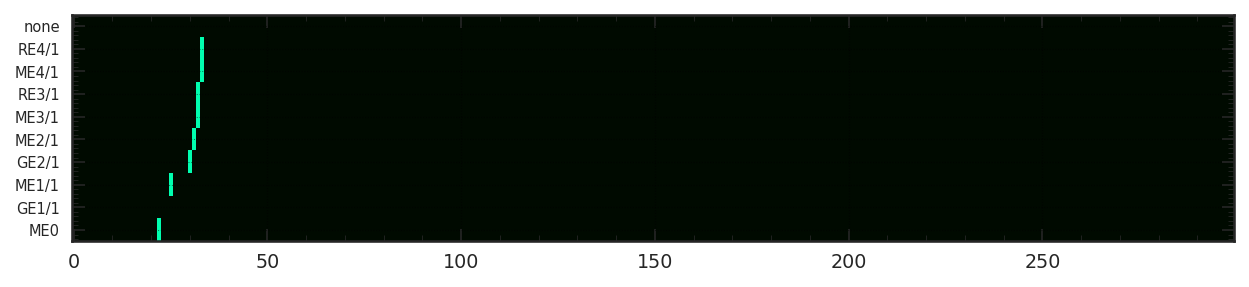

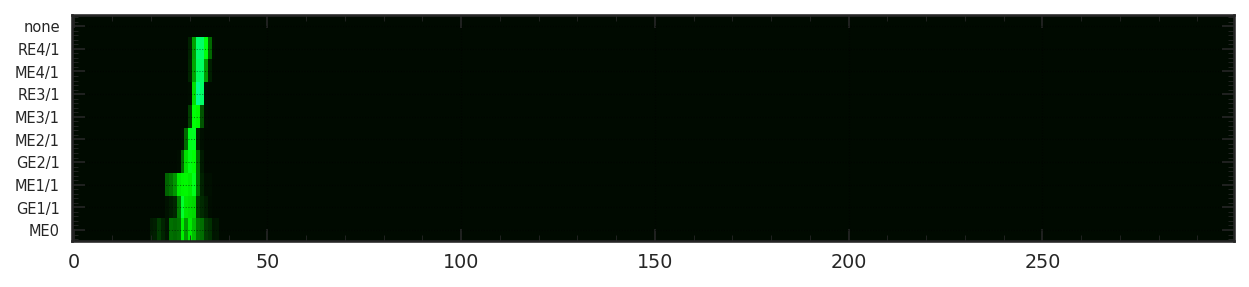

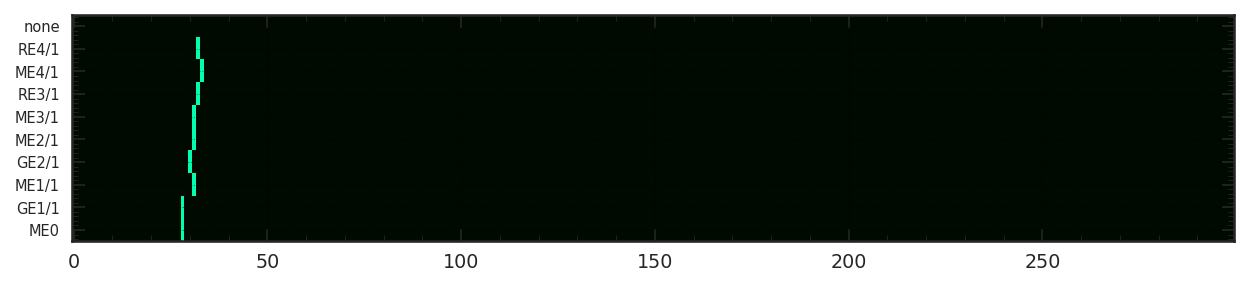

(array([0, 2, 3, 4, 5, 6, 7, 8]), array([22, 25, 30, 31, 32, 32, 33, 33]))
(array([0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 6, 6, 6, 7, 7,
       8, 8, 8]), array([28, 30, 28, 29, 30, 27, 28, 29, 30, 31, 29, 30, 31, 30, 31, 31, 32,
       31, 32, 33, 32, 33, 32, 33, 34]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([28, 28, 31, 30, 31, 31, 32, 33, 32]))
0.0 0.9204679 0.007920334


In [20]:
display_image(zone, test_img, cmap=green_hot)
display_image(zone, test_img_eval, cmap=green_hot)
display_image(zone, test_img_eval_nms, cmap=green_hot)

print(np.nonzero(test_img[...,0] > 0.5))
print(np.nonzero(test_img_eval[...,0] > 0.5))
print(np.nonzero(test_img_eval_nms[...,0] > 0.5))

print(np.min(test_img_eval), np.max(test_img_eval), np.mean(test_img_eval))